# Import and Install

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Uninstall the current version of pandas
!pip uninstall -y pandas

# Install pandas version 1.3.5
!pip install pandas==1.3.5

# Import pandas and print the version to confirm the installation
import pandas as pd
print(f"Installed pandas version: {pd.__version__}")

!pip install natsort plotly matplotlib scikit-learn seaborn imageio wandb google-cloud-bigquery


Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Successfully uninstalled pandas-1.3.5
  Using cached pandas-1.3.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.11.1 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.3.5 which is incompatible.
plotnine 0.12.4 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
statsmodels 0.14.2 requires pandas!=2.1.0,>=1.4, but you have pandas 1.3.5 which is incompatible.
xarray 2023.7.0 requires pandas>=1.4, but you have pandas 1.3.5 which is incompatible.


Installed pandas version: 1.3.5


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging
from IPython.display import display, HTML
import sys
import os
from joblib import dump
from sklearn import tree
import google.colab.data_table
import importlib.util
import time
import gc
import glob
import matplotlib.pyplot as plt

In [9]:
!pip install /content/drive/My\ Drive/ML_Nuclear_Data/nucml-1.0.5-dev.1/nucml-1.0.5-dev.1
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow xgboost
!python -c "import nucml.configure as config; config.configure('.', 'acedata/', matlab_exe_path='/mnt/c/Program\ Files/MATLAB/R2019a/bin/matlab.exe')"

Processing ./drive/My Drive/ML_Nuclear_Data/nucml-1.0.5-dev.1/nucml-1.0.5-dev.1
  Preparing metadata (setup.py) ... done
  Created wheel for nucml: filename=nucml-1.0.5.dev1-py3-none-any.whl size=255178 sha256=324fd82cfb571f4d1da59c9615718fe457ac5832e636393c815fb0909aa64524
  Stored in directory: /root/.cache/pip/wheels/84/d4/b6/c694cba4d407d574476552aab353f8a7cd263211ebb48723ff
Successfully built nucml
  Attempting uninstall: nucml
    Found existing installation: nucml 1.0.5.dev1
    Uninstalling nucml-1.0.5.dev1:
      Successfully uninstalled nucml-1.0.5.dev1


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-j1i6x_yi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-j1i6x_yi
  Resolved https://github.com/tensorflow/docs to commit 773bcc865af5d5a45b405c80faf6fcc3cc510d7d
  Preparing metadata (setup.py) ... done
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.10/dist-packages/nucml/configure.py", line 6, in <module>
    drive.mount('/content/drive')
  File "/usr/local/lib/python3.10/dist-packages/google/colab/drive.py", line 100, in mount
    return _mount(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/drive.py", line 133, in _mount
    _message.blocking_request(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_message.py", line 173, in blocking_request
    request_id = send_request(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_message.py", line 117, in send_request
 

In [10]:
# Loading the modules for further use if needed
import nucml.ace.data_utilities as ace_utils              # pylint: disable=import-error
import nucml.evaluation.data_utilities as endf_utils      # pylint: disable=import-error
import nucml.datasets as nuc_data                         # pylint: disable=import-error
import nucml.model.utilities as model_utils               # pylint: disable=import-error
import nucml.plot.utilities as plot_utils                 # pylint: disable=import-error
import nucml.general_utilities as gen_utils               # pylint: disable=import-error
import nucml.exfor.plot as exfor_plot_utils               # pylint: disable=import-error
import nucml.config as config                             # pylint: disable=import-error
import nucml.exfor.data_utilities as exfor_utils


# Loading DT Training Results

In [11]:
import google.colab.data_table as data_table
# Define the model date
model_date = '19.07.24EScaled'
# Use f-string to construct the directory path
directory_path = f'/content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/{model_date}'
print(directory_path)  # For verification


/content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled


In [12]:

# List folders in directory function
def list_folders_in_directory(directory_path):
    try:
        # List all items in the directory
        items = os.listdir(directory_path)
        # Filter out only folders
        folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
        # Extract relevant labels from folder names
        folder_labels = [folder.split('_log')[0] for folder in folders]

        # Print each folder and its extracted label
        print(f"Folders in '{directory_path}':")
        for folder, label in zip(folders, folder_labels):
            print(f"{folder} -> {label}")

        return folders, folder_labels
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

# Call the function and get the labels
folders, folder_labels = list_folders_in_directory(directory_path)
print(f"Extracted folder labels: {folder_labels}")

# Initialize an empty dictionary to hold results dataframes
results_dict = {}

# Load CSV files from each folder
for folder, label in zip(folders, folder_labels):
    # Use glob to find the file that begins with "all_results" in the folder
    csv_files = glob.glob(os.path.join(directory_path, folder, "all_results*.csv"))

    if not csv_files:
        print(f"No CSV file found for {label} in {os.path.join(directory_path, folder)}")
        continue

    # Take the first match, assuming there's only one relevant file
    csv_path = csv_files[0]
    try:
        results_dict[label] = pd.read_csv(csv_path).sort_values(by="max_depth")
    except FileNotFoundError:
        print(f"CSV file not found for {label} at {csv_path}")
    except Exception as e:
        print(f"An error occurred while reading CSV for {label}: {e}")

# Find the minimum train_mae for each dataset
min_train_mae = {label: df.train_mae.min() for label, df in results_dict.items()}
best_dataset_train_mae = pd.DataFrame({"Train_MAE": list(min_train_mae.values()), "Dataset": list(min_train_mae.keys())})
best_dataset_train_mae = best_dataset_train_mae[best_dataset_train_mae.Train_MAE == best_dataset_train_mae.Train_MAE.min()]
print("Best dataset based on Train MAE:")
print(best_dataset_train_mae)

# Find the minimum val_mae for each dataset
min_val_mae = {label: df.val_mae.min() for label, df in results_dict.items()}
best_dataset_val_mae = pd.DataFrame({"Val_MAE": list(min_val_mae.values()), "Dataset": list(min_val_mae.keys())})
best_dataset_val_mae = best_dataset_val_mae[best_dataset_val_mae.Val_MAE == best_dataset_val_mae.Val_MAE.min()]
print("Best dataset based on Validation MAE:")
print(best_dataset_val_mae)

Folders in '/content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled':
Energy Scaled_basic=1_neutrons -> Energy Scaled_basic=1_neutrons
Extracted folder labels: ['Energy Scaled_basic=1_neutrons']
Best dataset based on Train MAE:
   Train_MAE                         Dataset
0   0.094953  Energy Scaled_basic=1_neutrons
Best dataset based on Validation MAE:
    Val_MAE                         Dataset
0  0.120669  Energy Scaled_basic=1_neutrons


In [13]:
# Function to load all results from CSV files and add labels
def load_all_results_with_labels(base_directory, folders, labels):
    results_dict = {}
    index = 0
    # Alphabet list for labels
    alphabet_labels = [chr(i) for i in range(65, 65 + len(folders))]  # 'A', 'B', 'C', ...

    for folder, label in zip(folders, labels):
        dir_path = os.path.join(base_directory, folder)
        print(f"Searching in: {dir_path}")

        try:
            all_files = os.listdir(dir_path)
            print(f"All files in {dir_path}: {all_files}")

            csv_files = [f for f in all_files if f.startswith('all_results') and f.endswith('.csv')]
            print(f"Found {len(csv_files)} CSV files in {dir_path}")

            if not csv_files:
                print(f"No CSV files found in {dir_path}, check directory and file permissions.")

            for csv_file in csv_files:
                csv_path = os.path.join(dir_path, csv_file)
                print(f"Found CSV file: {csv_path}")
                try:
                    df = pd.read_csv(csv_path).sort_values(by="max_depth")
                    df['labels'] = label  # Add extracted folder label
                    alpha_label = alphabet_labels[index]  # Get the corresponding alphabet label
                    df['letter'] = alpha_label  # Add alphabet label to DataFrame

                    # Manually update model_path and scaler_path
                    df['model_path'] = df['model_path'].apply(lambda x: x if os.path.isabs(x) else os.path.join(dir_path, x))
                    df['scaler_path'] = df['scaler_path'].apply(lambda x: x if os.path.isabs(x) else os.path.join(dir_path, x))

                    results_dict[f'results_{alpha_label}'] = df
                    print(f"Loaded {csv_path} as results_{alpha_label} with label '{label}' successfully.")
                    index += 1
                except Exception as e:
                    print(f"Error loading {csv_path}: {e}")
        except Exception as e:
            print(f"Error accessing {dir_path}: {e}")

    return results_dict

# Load all results and add labels
results_dict = load_all_results_with_labels(directory_path, folders, folder_labels)

# Verify that all DataFrames are loaded into results_dict
print(f"Loaded DataFrames: {list(results_dict.keys())}")

# Assign the DataFrames to variables in the global namespace
for label, df in results_dict.items():
    globals()[label] = df

# Concatenate all results into a single DataFrame
all_results = pd.concat(results_dict.values(), ignore_index=True)

# Reorder and rename columns
desired_columns = ['letter', 'labels', 'id', 'model_path', 'scaler_path', 'test_mae', 'val_mae', 'train_mae',
                   'max_depth', 'mss', 'msl', 'mt_strategy', 'normalizer', 'train_mse', 'train_evs',
                   'train_mae_m', 'train_r2', 'val_mse', 'val_evs', 'val_mae_m', 'val_r2', 'test_mse',
                   'test_evs', 'test_mae_m', 'test_r2', 'training_time']

# Ensure all columns exist in the DataFrame
for col in desired_columns:
    if col not in all_results.columns:
        all_results[col] = None  # Add missing columns with None values

# Reorder columns according to the desired structure
all_results = all_results[desired_columns]

# Function to update paths
def update_paths(row, base_directory, folders, folder_labels):
    # Find the corresponding folder for the label
    label = row['labels']
    if label in folder_labels:
        folder = folders[folder_labels.index(label)]
        folder_path = os.path.join(base_directory, folder)
    else:
        print(f"Warning: Label '{label}' not found in folder_labels.")
        folder_path = base_directory

    if not row['model_path'].startswith(base_directory):
        stripped_model_path = os.path.basename(row['model_path'])
        row['model_path'] = os.path.join(folder_path, stripped_model_path)

    if not row['scaler_path'].startswith(base_directory):
        stripped_scaler_path = os.path.basename(row['scaler_path'])
        row['scaler_path'] = os.path.join(folder_path, stripped_scaler_path)

    return row

# Apply the function to all rows in the DataFrame
all_results = all_results.apply(update_paths, axis=1, base_directory=directory_path, folders=folders, folder_labels=folder_labels)

# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# Enable the data table display mode for pandas DataFrames
data_table.enable_dataframe_formatter()

# Select only the specified columns
selected_columns = ['letter', 'labels', 'id', 'model_path', 'scaler_path', 'test_mae', 'val_mae', 'train_mae', 'max_depth', 'mss', 'msl']
filtered_results = all_results[selected_columns]

# Display the filtered DataFrame
data_table.DataTable(filtered_results)

# Save the new DataFrame as all_resultsFP
all_resultsFP = all_results.copy()

# Display the new DataFrame
data_table.DataTable(all_resultsFP)

# Print the dataset labels for each DataFrame
print("\nDataset Labels for Results DataFrames:")
for letter in all_results['letter'].unique():
    print(f"{letter}: {all_results[all_results['letter'] == letter]['labels'].unique()}")

Searching in: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons
All files in /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons: ['column_headers.csv', 'scaler.pkl', 'dt_model_1_mss6_msl7_maxdepth76.joblib', 'dt_model_2_mss6_msl8_maxdepth76.joblib', 'dt_model_3_mss7_msl7_maxdepth76.joblib', 'dt_model_4_mss7_msl8_maxdepth76.joblib', 'dt_model_5_mss6_msl7_maxdepth82.joblib', 'dt_model_6_mss6_msl8_maxdepth82.joblib', 'dt_model_7_mss7_msl7_maxdepth82.joblib', 'dt_model_8_mss7_msl8_maxdepth82.joblib', 'all_results_maxdepth(76-82)_mss(6-7)_msl(7-8).csv']
Found 1 CSV files in /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons
Found CSV file: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/all_results_maxdepth(76-82)_mss(6-7)_msl(7-8).csv
Loaded /content/drive/My Drive/


Dataset Labels for Results DataFrames:
A: ['Energy Scaled_basic=1_neutrons']


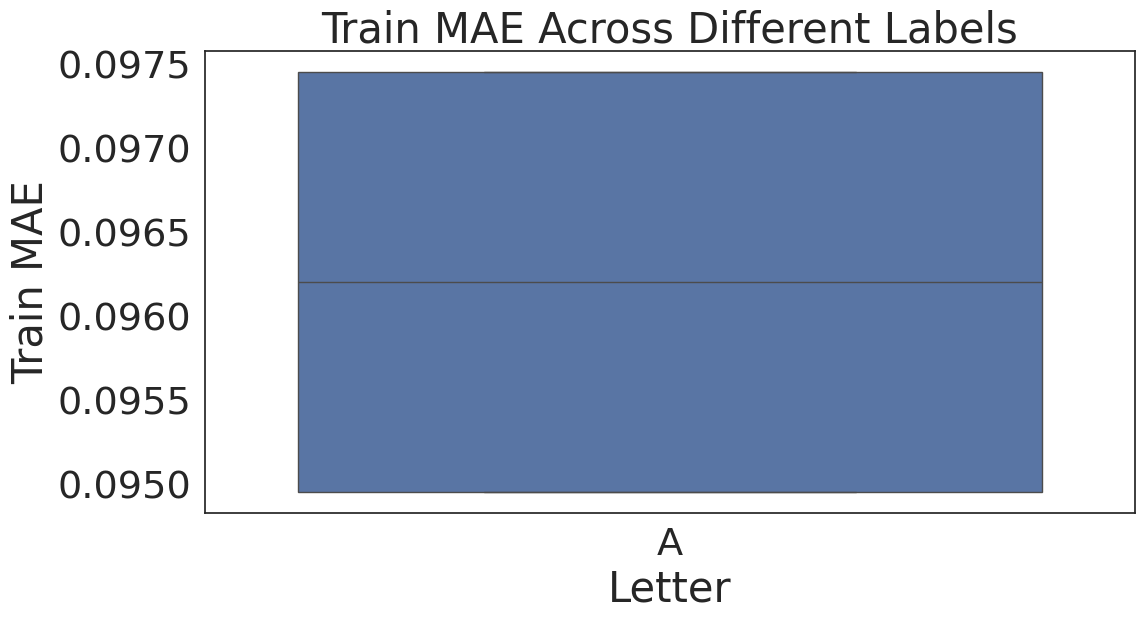

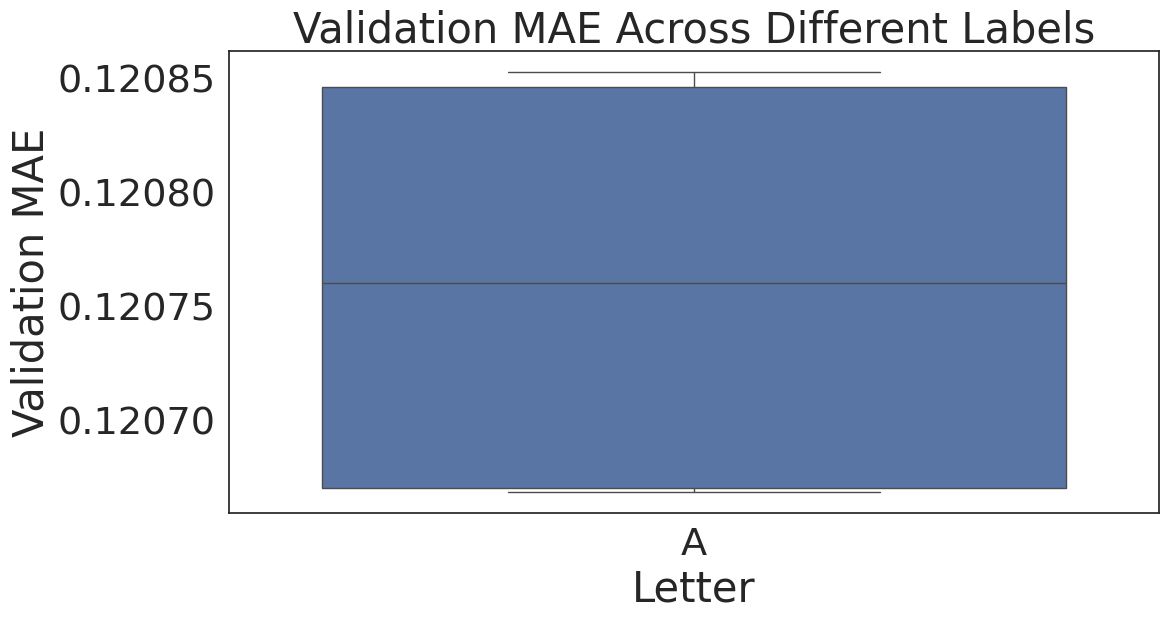

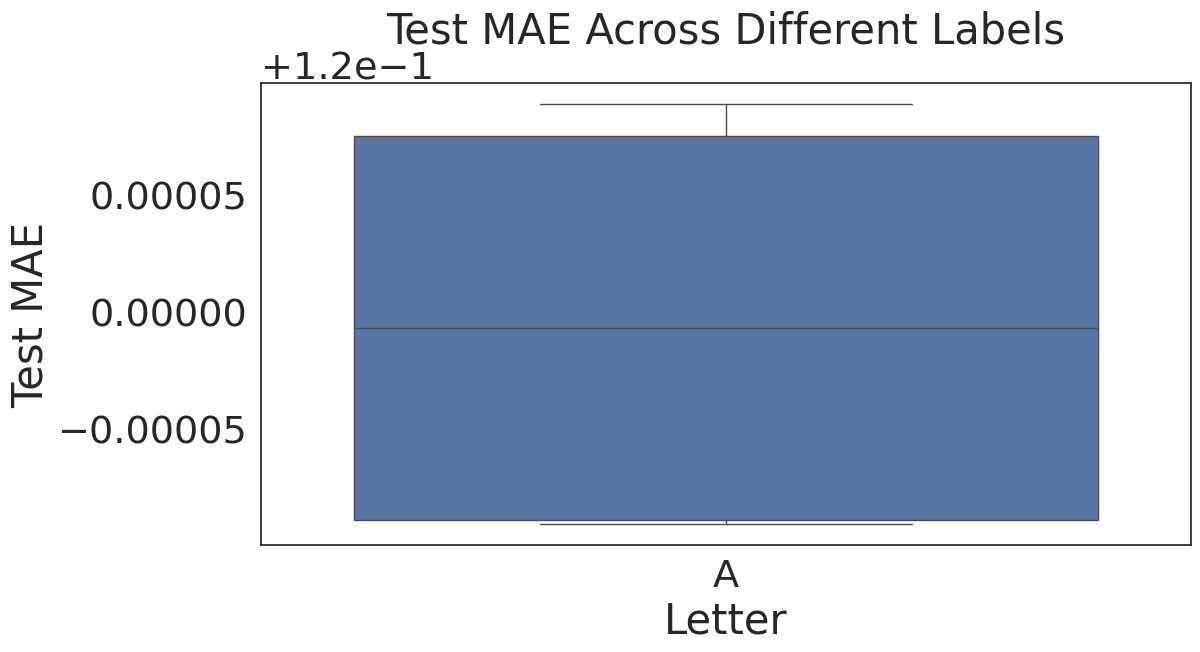


Dataset Labels for Results DataFrames:
results_A: ['Energy Scaled_basic=1_neutrons']


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# Print the dataset labels for each DataFrame
print("\nDataset Labels for Results DataFrames:")
for letter in all_results['letter'].unique():
    print(f"{letter}: {all_results[all_results['letter'] == letter]['labels'].unique()}")
# Compare train_mae across different labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='letter', y='train_mae', data=all_results)
plt.title('Train MAE Across Different Labels')
plt.xlabel('Letter')
plt.ylabel('Train MAE')
plt.show()

# Compare val_mae across different labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='letter', y='val_mae', data=all_results)
plt.title('Validation MAE Across Different Labels')
plt.xlabel('Letter')
plt.ylabel('Validation MAE')
plt.show()

# Compare test_mae across different labels
plt.figure(figsize=(12, 6))
sns.boxplot(x='letter', y='test_mae', data=all_results)
plt.title('Test MAE Across Different Labels')
plt.xlabel('Letter')
plt.ylabel('Test MAE')
plt.show()
plt.show()
# Print the dataset labels for each DataFrame
print("\nDataset Labels for Results DataFrames:")
for label, df in results_dict.items():
    print(f"{label}: {df['labels'].unique()}")

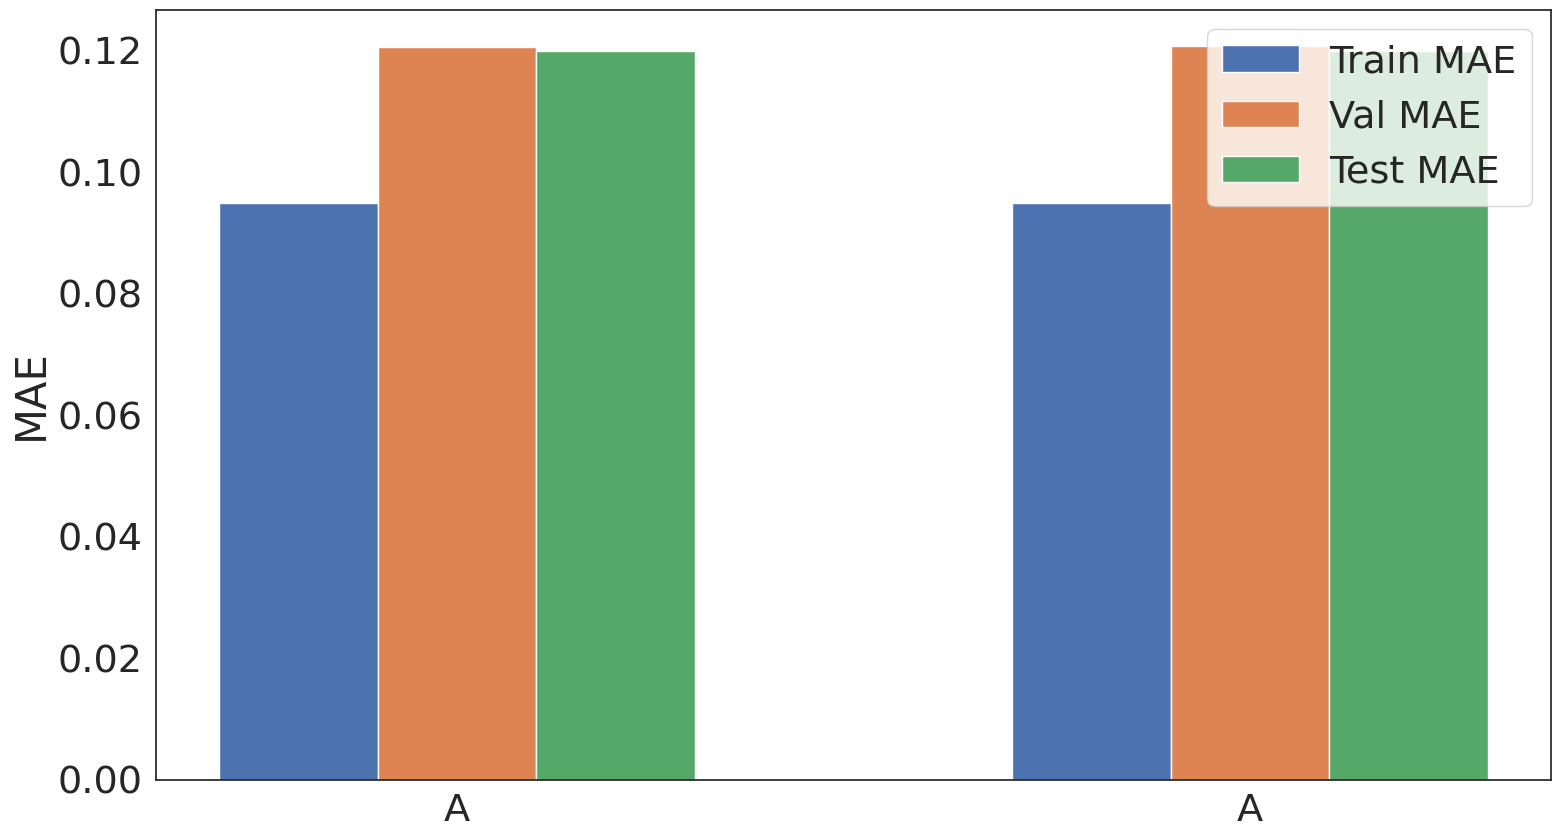


Dataset Labels for Results DataFrames:
results_A: ['Energy Scaled_basic=1_neutrons']


In [16]:
# Apply the function to get the top 1 result for each dataset based on train_mae
top_n = 2  # Number of top results to fetch
sort_by_column = 'test_mae'  # Column to sort by

# Function to get the top result for each dataset based on train_mae
def get_top_n_results(results_dict, top_n, sort_by_column):
    top_results_dict = {}
    for label, df in results_dict.items():
        sorted_df = df.sort_values(by=sort_by_column).head(top_n)
        top_results_dict[label] = sorted_df
    return top_results_dict


top_results_dict = get_top_n_results(results_dict, top_n, sort_by_column)

# Concatenate the top results into a single DataFrame
top_all_results = pd.concat(top_results_dict.values(), ignore_index=True)
google.colab.data_table.DataTable(top_all_results)

# Extract MAE values for plotting
train_mae = top_all_results["train_mae"].values
val_mae = top_all_results["val_mae"].values
test_mae = top_all_results["test_mae"].values

# Define x-axis labels
x_labels = top_all_results['letter'].values

x = np.arange(len(top_all_results))  # the label locations
width = 0.2  # the width of the bars

# Plot the MAE values
fig, ax = plt.subplots(figsize=(18,10))
rects1 = ax.bar(x - width, train_mae, width, label='Train MAE')
rects2 = ax.bar(x, val_mae, width, label='Val MAE')
rects3 = ax.bar(x + width, test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=0)
ax.legend()

plt.show()

# Print the dataset labels for each DataFrame
print("\nDataset Labels for Results DataFrames:")
for label, df in results_dict.items():
    print(f"{label}: {df['labels'].unique()}")


## HyperParameter Exploration

In [ ]:

plot = results_A  # Replace this with the desired DataFrame

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Print the dataset labels for each DataFrame
print("\nDataset Labels for Results DataFrames:")
for label, df in results_dict.items():
    print(f"{label}: {df['labels'].unique()}")



Dataset Labels for Results DataFrames:
results_A: ['All_basic=3_neutrons']
results_B: ['LimitedRows=20000_basic=3_neutrons']
results_C: ['Fraction=0.6_basic=3_neutrons']


Max Depth Range: (70, 88)
MSS Range: (6, 8)
MSL Range: (6, 8)


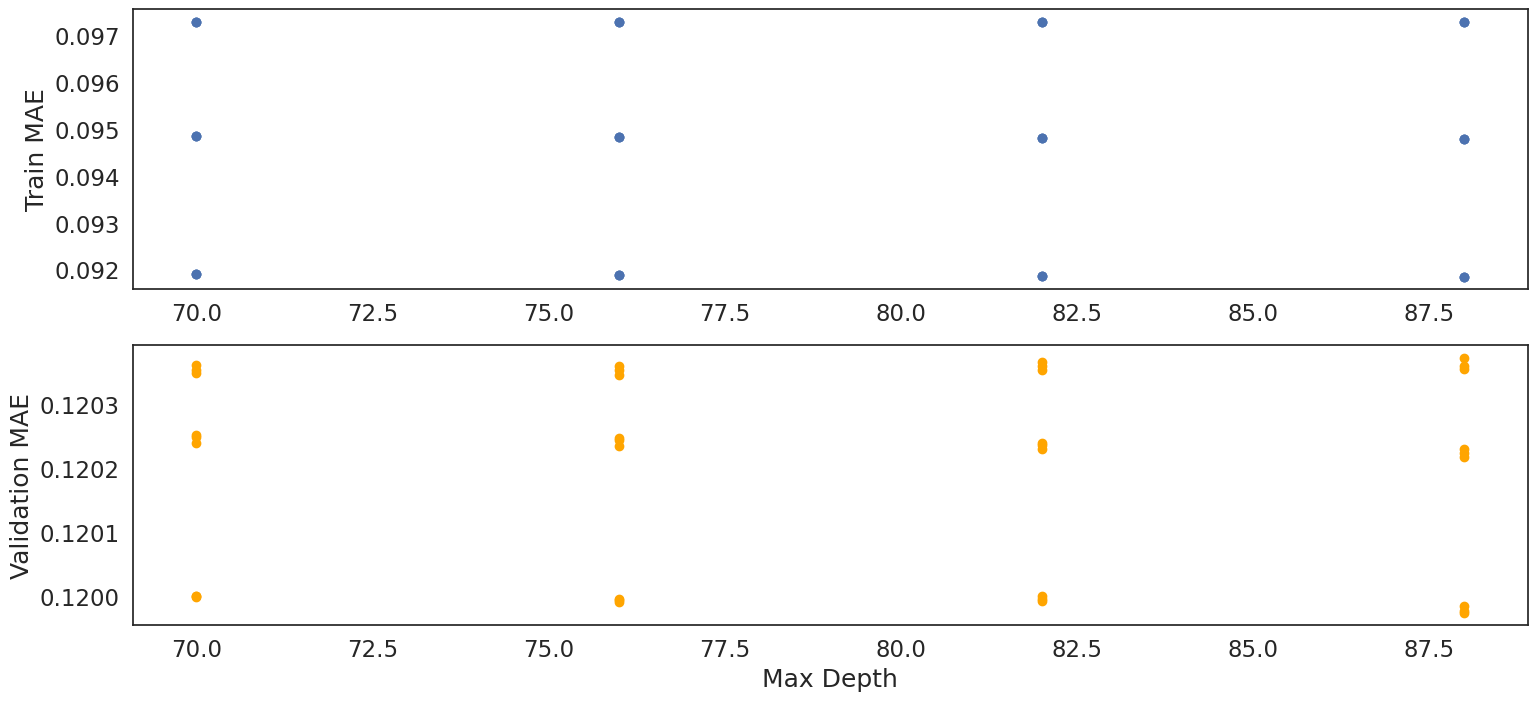

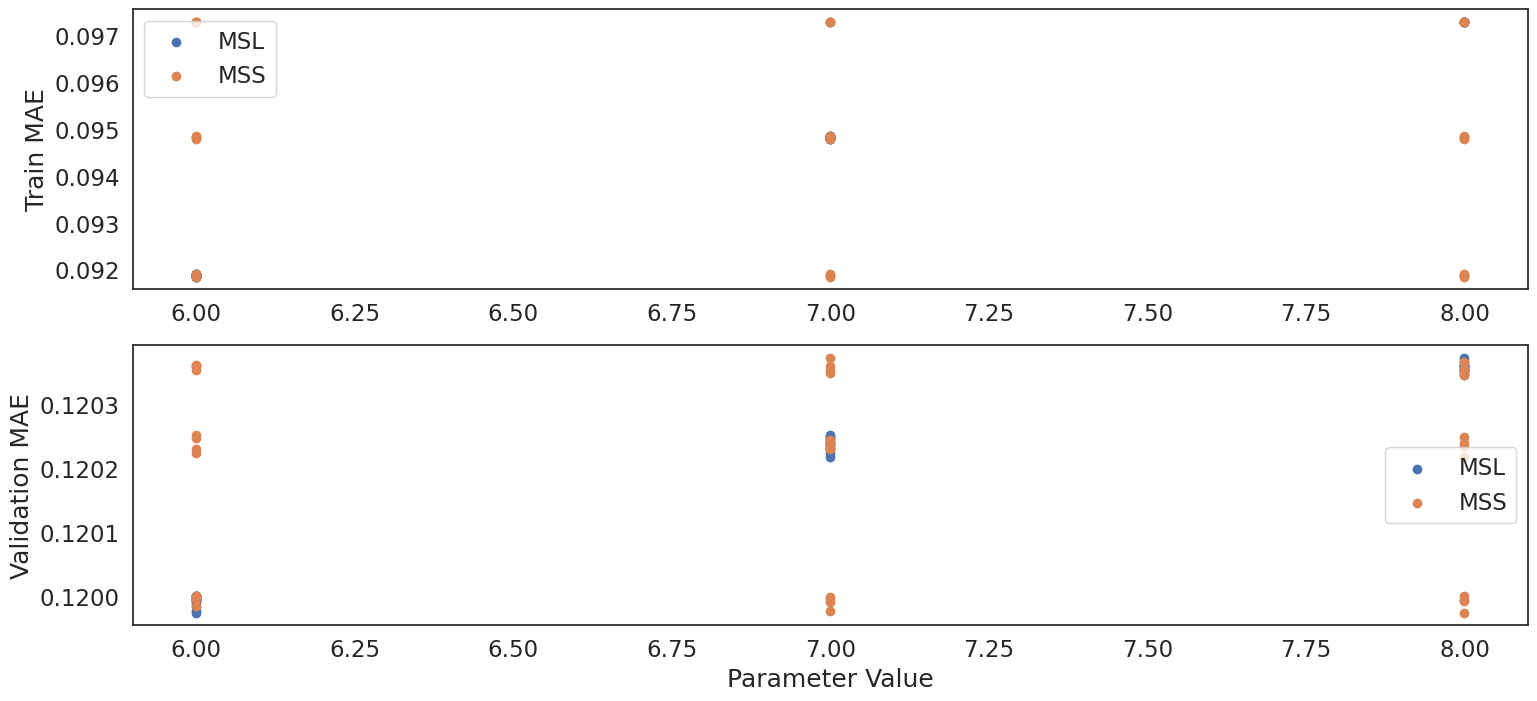

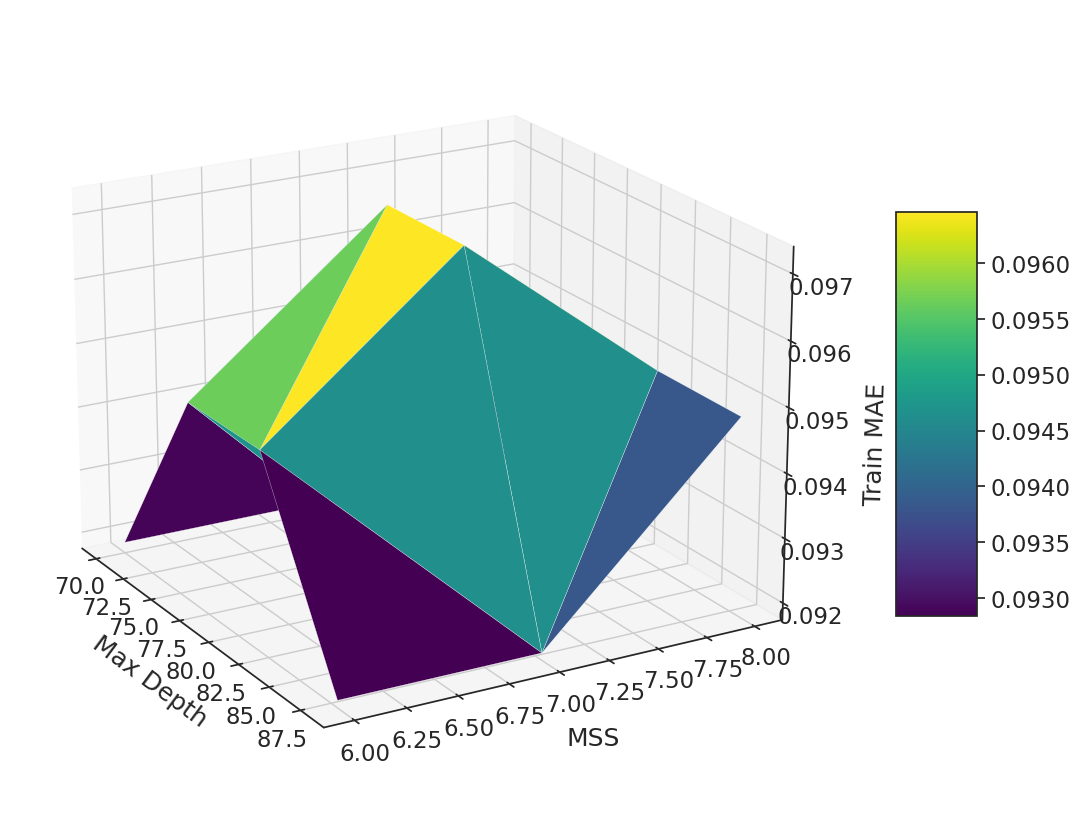

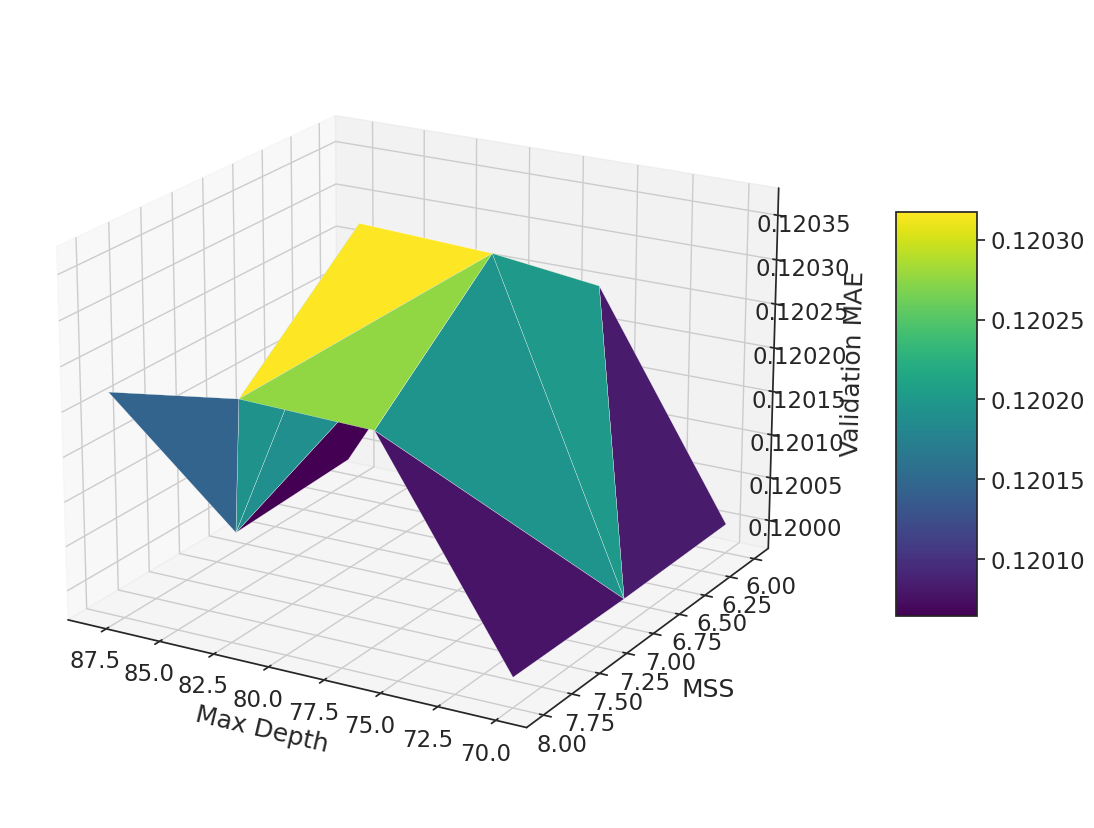

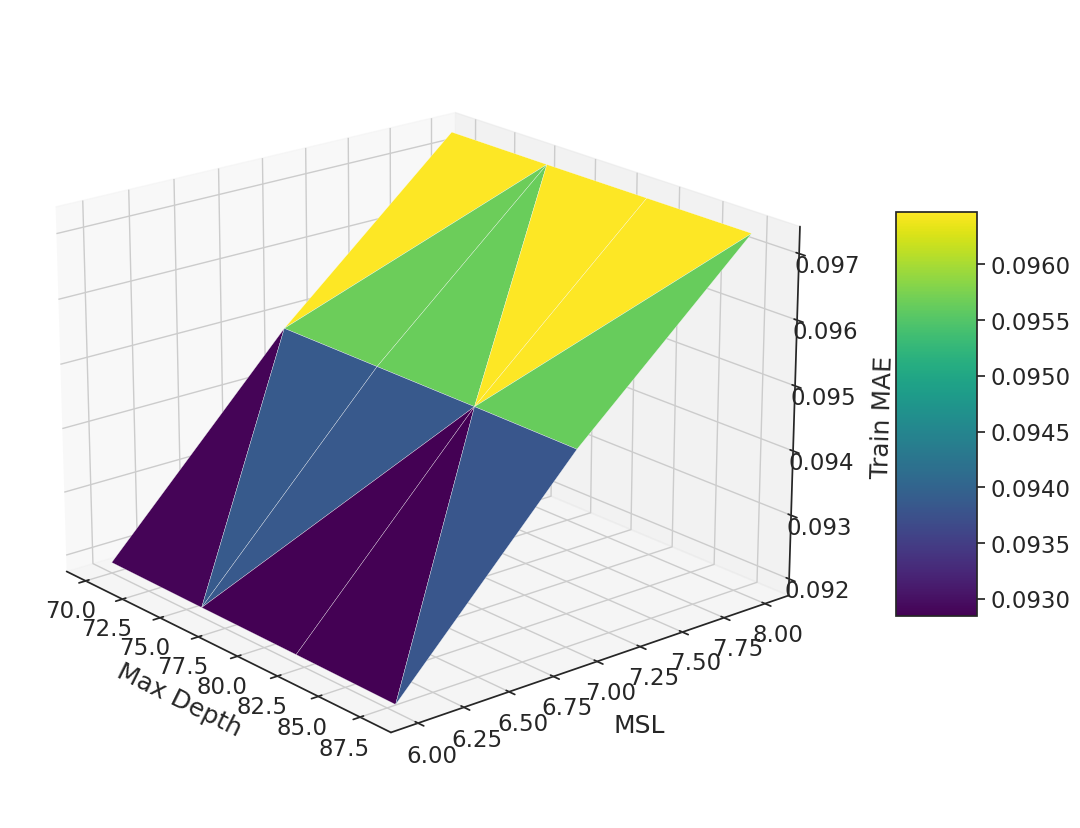

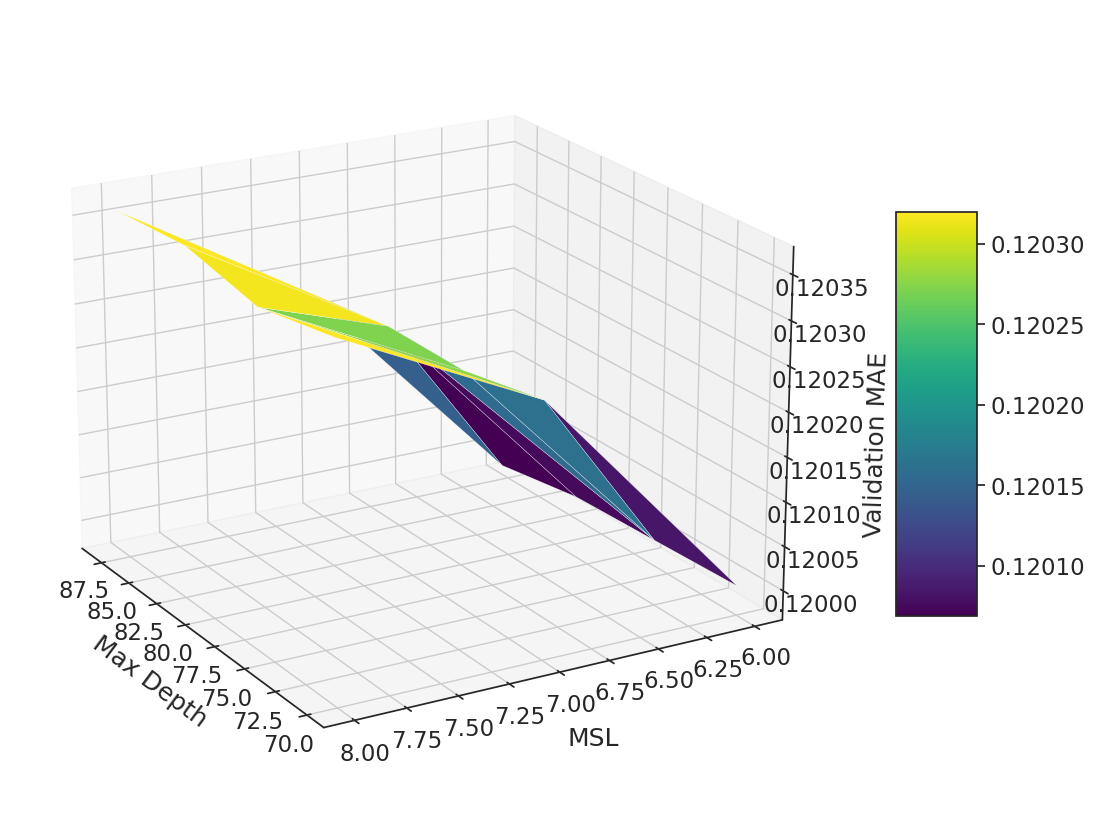

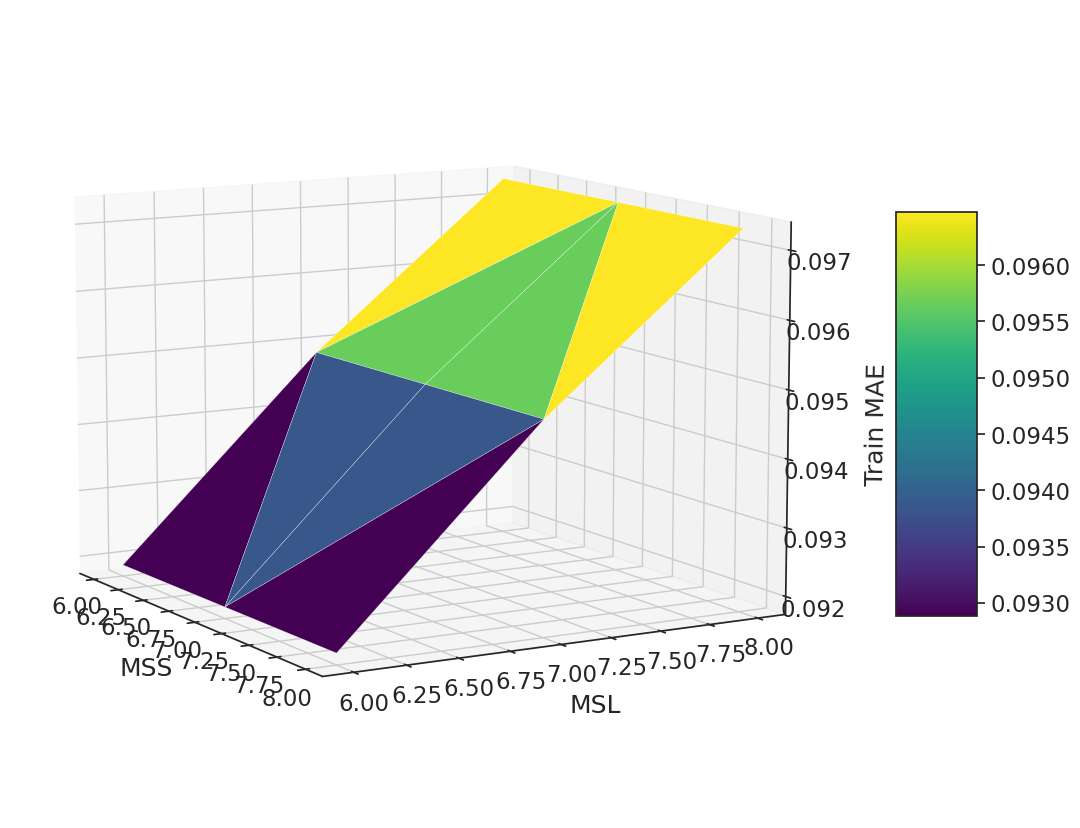

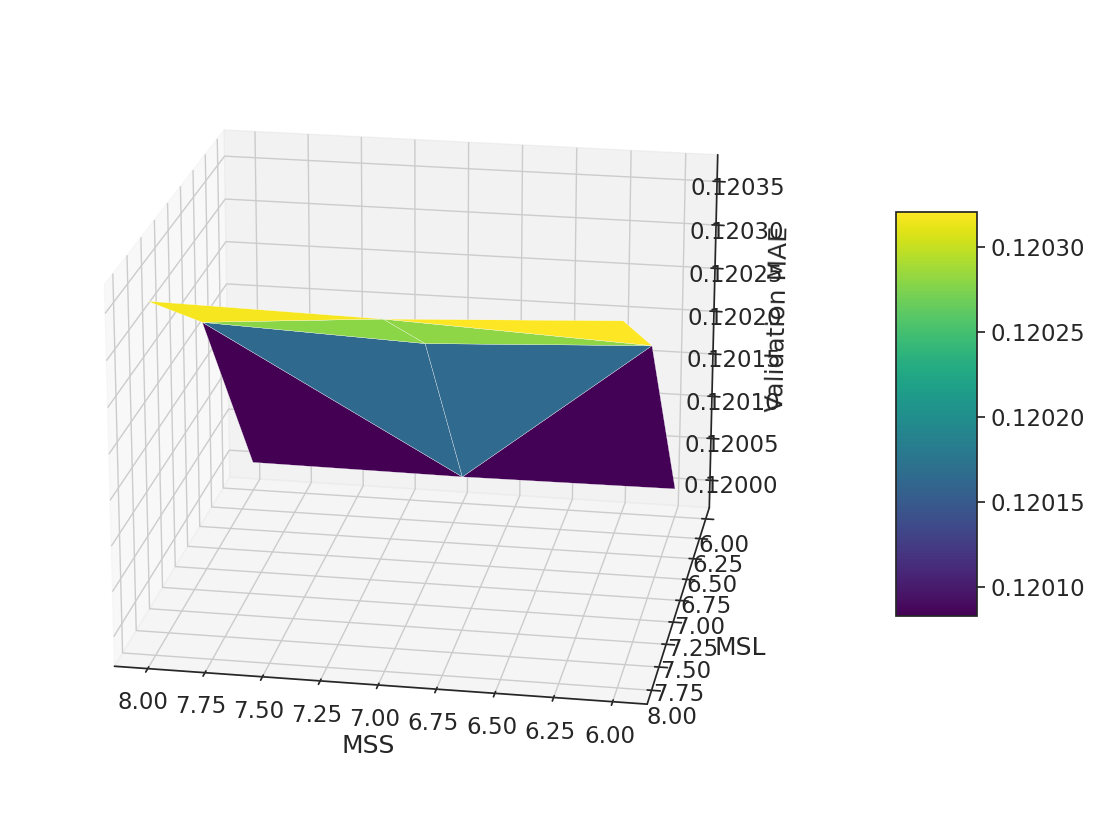

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def max_depth_plot(df, save=False, name="max_depth_plot", close=False):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 8))
    ax1.scatter(df.max_depth, df.train_mae)
    ax2.scatter(df.max_depth, df.val_mae, c="orange")
    ax2.set_xlabel("Max Depth")
    ax1.set_ylabel("Train MAE")
    ax2.set_ylabel("Validation MAE")
    if save:
        plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
    if close:
        plt.close()

max_depth_plot(results_A)

def mss_msl_plot(df, save=False, name="mss_msl_plot", close=False):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(18, 8))
    ax1.scatter(df.msl, df.train_mae, label="MSL")
    ax1.scatter(df.mss, df.train_mae, label="MSS")
    ax2.scatter(df.msl, df.val_mae, label="MSL")
    ax2.scatter(df.mss, df.val_mae, label="MSS")
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("Parameter Value")
    ax1.set_ylabel("Train MAE")
    ax2.set_ylabel("Validation MAE")
    if save:
        plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
    if close:
        plt.close()

mss_msl_plot(results_A)

def plot_trisurf(df, x_col, y_col, z_col, view_init_elev, view_init_azim, xlabel, ylabel, zlabel, fig_size=(20, 10.5), cmap=cm.viridis):
    # Create a figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(*fig_size, forward=True)

    # Plot the trisurf
    surf = ax.plot_trisurf(df[x_col], df[y_col], df[z_col], linewidth=0.2, antialiased=True, cmap=cmap)

    # Set view, labels, and colorbar
    ax.view_init(view_init_elev, view_init_azim)
    ax.set_xlabel(xlabel, labelpad=10)
    ax.set_ylabel(ylabel, labelpad=15)
    ax.set_zlabel(zlabel, labelpad=15)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Show the plot
    plt.show()

# Determine the range for hyperparameters
max_depth_range = (results_A.max_depth.min(), results_A.max_depth.max())
mss_range = (results_A.mss.min(), results_A.mss.max())
msl_range = (results_A.msl.min(), results_A.msl.max())

# Print the ranges for verification
print(f"Max Depth Range: {max_depth_range}")
print(f"MSS Range: {mss_range}")
print(f"MSL Range: {msl_range}")

# Plot 1
plot_trisurf(
    results_A, 'max_depth', 'mss', 'train_mae',
    view_init_elev=20, view_init_azim=-30,
    xlabel="Max Depth", ylabel="MSS", zlabel="Train MAE"
)

# Plot 2
plot_trisurf(
    results_A, 'max_depth', 'mss', 'val_mae',
    view_init_elev=20, view_init_azim=120,
    xlabel="Max Depth", ylabel="MSS", zlabel="Validation MAE"
)

# Plot 3
plot_trisurf(
    results_A, 'max_depth', 'msl', 'train_mae',
    view_init_elev=20, view_init_azim=-40,
    xlabel="Max Depth", ylabel="MSL", zlabel="Train MAE"
)

# Plot 4
plot_trisurf(
    results_A, 'max_depth', 'msl', 'val_mae',
    view_init_elev=20, view_init_azim=150,
    xlabel="Max Depth", ylabel="MSL", zlabel="Validation MAE"
)

# Plot 5
plot_trisurf(
    results_A, 'mss', 'msl', 'train_mae',
    view_init_elev=10, view_init_azim=-30,
    xlabel="MSS", ylabel="MSL", zlabel="Train MAE"
)

# Plot 6
plot_trisurf(
    results_A, 'mss', 'msl', 'val_mae',
    view_init_elev=20, view_init_azim=100,
    xlabel="MSS", ylabel="MSL", zlabel="Validation MAE"
)


In [ ]:
import plotly.express as px
import os

# Ensure the directory for saving figures exists
os.makedirs("figures/Parameter_Tuning", exist_ok=True)

def create_3d_scatter_plot(df, x, y, z, color, title):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color, title=title)
    fig.update_layout(scene=dict(
        xaxis_title=x,
        yaxis_title=y,
        zaxis_title=z),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10)
    )
    fig.show()

# Generate 3D scatter plots for each dataset
for letter, df in results_dict.items():
    # Plot for 'train_mae' against 'max_depth' and 'msl'
    create_3d_scatter_plot(df, 'max_depth', 'msl', 'train_mae', 'train_mae',
                           f"Minimum Samples in Leaf - Train Dataset ({letter})")

    # Plot for 'test_mae' against 'max_depth' and 'msl'
    create_3d_scatter_plot(df, 'max_depth', 'msl', 'test_mae', 'test_mae',
                           f"Minimum Samples in Leaf - Test Dataset ({letter})")

    # Plot for 'train_mae' against 'max_depth' and 'mss'
    create_3d_scatter_plot(df, 'max_depth', 'mss', 'train_mae', 'train_mae',
                           f"Minimum Samples for Split - Train Dataset ({letter})")

    # Plot for 'test_mae' against 'max_depth' and 'mss'
    create_3d_scatter_plot(df, 'max_depth', 'mss', 'test_mae', 'test_mae',
                           f"Minimum Samples for Split - Test Dataset ({letter})")


## Gini Importance

In [17]:
# Function to load column headers and replace strings
def load_and_replace_column_headers(base_directory, folders, results_dict):
    columns_dict = {}
    letters = list(results_dict.keys())  # Extract the keys from results_dict (e.g., 'results_A', 'results_B')

    for folder, letter in zip(folders, letters):
        letter = letter.replace('results_', 'columns_')  # Replace 'results_' with 'columns_'
        dir_path = os.path.join(base_directory, folder)
        column_file = os.path.join(dir_path, 'column_headers.csv')  # Updated file name
        print(f"Loading column headers from: {column_file}")
        try:
            df = pd.read_csv(column_file).replace({
                "Center_of_Mass_Flag_Center_of_Mass": "Center of Mass",
                "Center_of_Mass_Flag_Lab": "Lab Frame"
            })
            columns_dict[letter] = df
            print(f"Loaded and processed {column_file} successfully.")
        except Exception as e:
            print(f"Error loading {column_file}: {e}")

    return columns_dict

# Load column headers
columns_dict = load_and_replace_column_headers(directory_path, folders, results_dict)

# Verify that all DataFrames are loaded into columns_dict
print(f"Loaded Column Headers DataFrames: {list(columns_dict.keys())}")

# Process each DataFrame to replace underscores with spaces in the 'data_columns' column
for label, df in columns_dict.items():
    columns_dict[label]['data_columns'] = columns_dict[label]['data_columns'].apply(lambda x: x.replace("_", " "))
    globals()[label] = columns_dict[label]

# Print the processed column headers for each DataFrame
#print("\nProcessed Column Headers DataFrames:")
#for label, df in columns_dict.items():
    #print(f"{label}:\n{df}\n")


Loading column headers from: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/column_headers.csv
Loaded and processed /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/column_headers.csv successfully.
Loaded Column Headers DataFrames: ['columns_A']


In [18]:
from joblib import load

def get_best_model_for_letter(df, letter):
    """Get the best model for a specific letter by sorting based on test_mae, val_mae, train_mae."""
    sorted_df = df.sort_values(by=['test_mae', 'val_mae', 'train_mae']).reset_index(drop=True)
    best_model_info = sorted_df.iloc[0]
    return best_model_info

def load_model_and_scaler(model_scaler_info, df=True, model_only=False):
    """Loads both the model and scaler given a dataframe with paths specified.

    Args:
        model_scaler_info (DataFrame): Must contain a "model_path" and a "scaler_path" feature if a DataFrame
            is passed. Else, it must contain the "model_path" and "scaler_path" as keys in a dictionary.
        df (bool, optional): If True, the model_scaler_info variable must be a DataFrame. If False, it must be
            a python dictionary.
        model_only (bool, optional): If True, the scaler will not be loaded. Only the model will be loaded.

    Returns:
        object, object: returns the loaded model and scaler.
    """
    if df:
        path_to_model = model_scaler_info["model_path"].values[0]
        path_to_scaler = model_scaler_info["scaler_path"].values[0]
    else:
        path_to_model = model_scaler_info["model_path"]
        path_to_scaler = model_scaler_info["scaler_path"]

    print(f"Loading model from: {path_to_model}")
    model = load(path_to_model)

    if not model_only:
        print(f"Loading scaler from: {path_to_scaler}")
        scaler = load(path_to_scaler)
        return model, scaler
    else:
        return model

def load_best_models_and_scalers(all_results):
    """Load the best models and scalers for each letter."""
    best_models_scalers = {}
    letters = all_results['letter'].unique()

    for letter in letters:
        df_letter = all_results[all_results['letter'] == letter]
        best_model_info = get_best_model_for_letter(df_letter, letter)

        model_scaler_info = {
            'model_path': best_model_info['model_path'],
            'scaler_path': best_model_info['scaler_path']
        }

        model, scaler = load_model_and_scaler(model_scaler_info, df=False)
        best_models_scalers[letter] = {'model': model, 'scaler': scaler, 'info': best_model_info}

    return best_models_scalers

# Load the best models and scalers for each letter
best_models_scalers = load_best_models_and_scalers(all_resultsFP)

# Print the loaded models and scalers information
for letter, data in best_models_scalers.items():
    print(f"Letter {letter}:")
    print(f"Model Path: {data['info']['model_path']}")
    print(f"Scaler Path: {data['info']['scaler_path']}")
    print(f"Test MAE: {data['info']['test_mae']}, Val MAE: {data['info']['val_mae']}, Train MAE: {data['info']['train_mae']}\n")

# Display the best models' DataFrame using google.colab.data_table
best_models_info_df = pd.DataFrame([data['info'] for data in best_models_scalers.values()])
import google.colab.data_table
google.colab.data_table.DataTable(best_models_info_df)


Loading model from: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/dt_model_1_mss6_msl7_maxdepth76.joblib
Loading scaler from: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/scaler.pkl
Letter A:
Model Path: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/dt_model_1_mss6_msl7_maxdepth76.joblib
Scaler Path: /content/drive/My Drive/ML_Nuclear_Data/ML_Saving_Directory/19.07.24EScaled/Energy Scaled_basic=1_neutrons/scaler.pkl
Test MAE: 0.1199091540684783, Val MAE: 0.1206686876582554, Train MAE: 0.0949534345447475



,letter,labels,id,model_path,scaler_path,test_mae,val_mae,train_mae,max_depth,mss,msl,mt_strategy,normalizer,train_mse,train_evs,train_mae_m,train_r2,val_mse,val_evs,val_mae_m,val_r2,test_mse,test_evs,test_mae_m,test_r2,training_time
0,A,Energy Scaled_basic=1_neutrons,1,/content/drive/My Drive/ML_Nuclear_Data/ML_Sav...,/content/drive/My Drive/ML_Nuclear_Data/ML_Sav...,0.119909,0.120669,0.094953,76,6,7,None,standard_scaler,0.038264,0.948882,None,0.948882,0.059906,0.919747,None,0.919746,0.058621,0.921742,None,0.921742,None


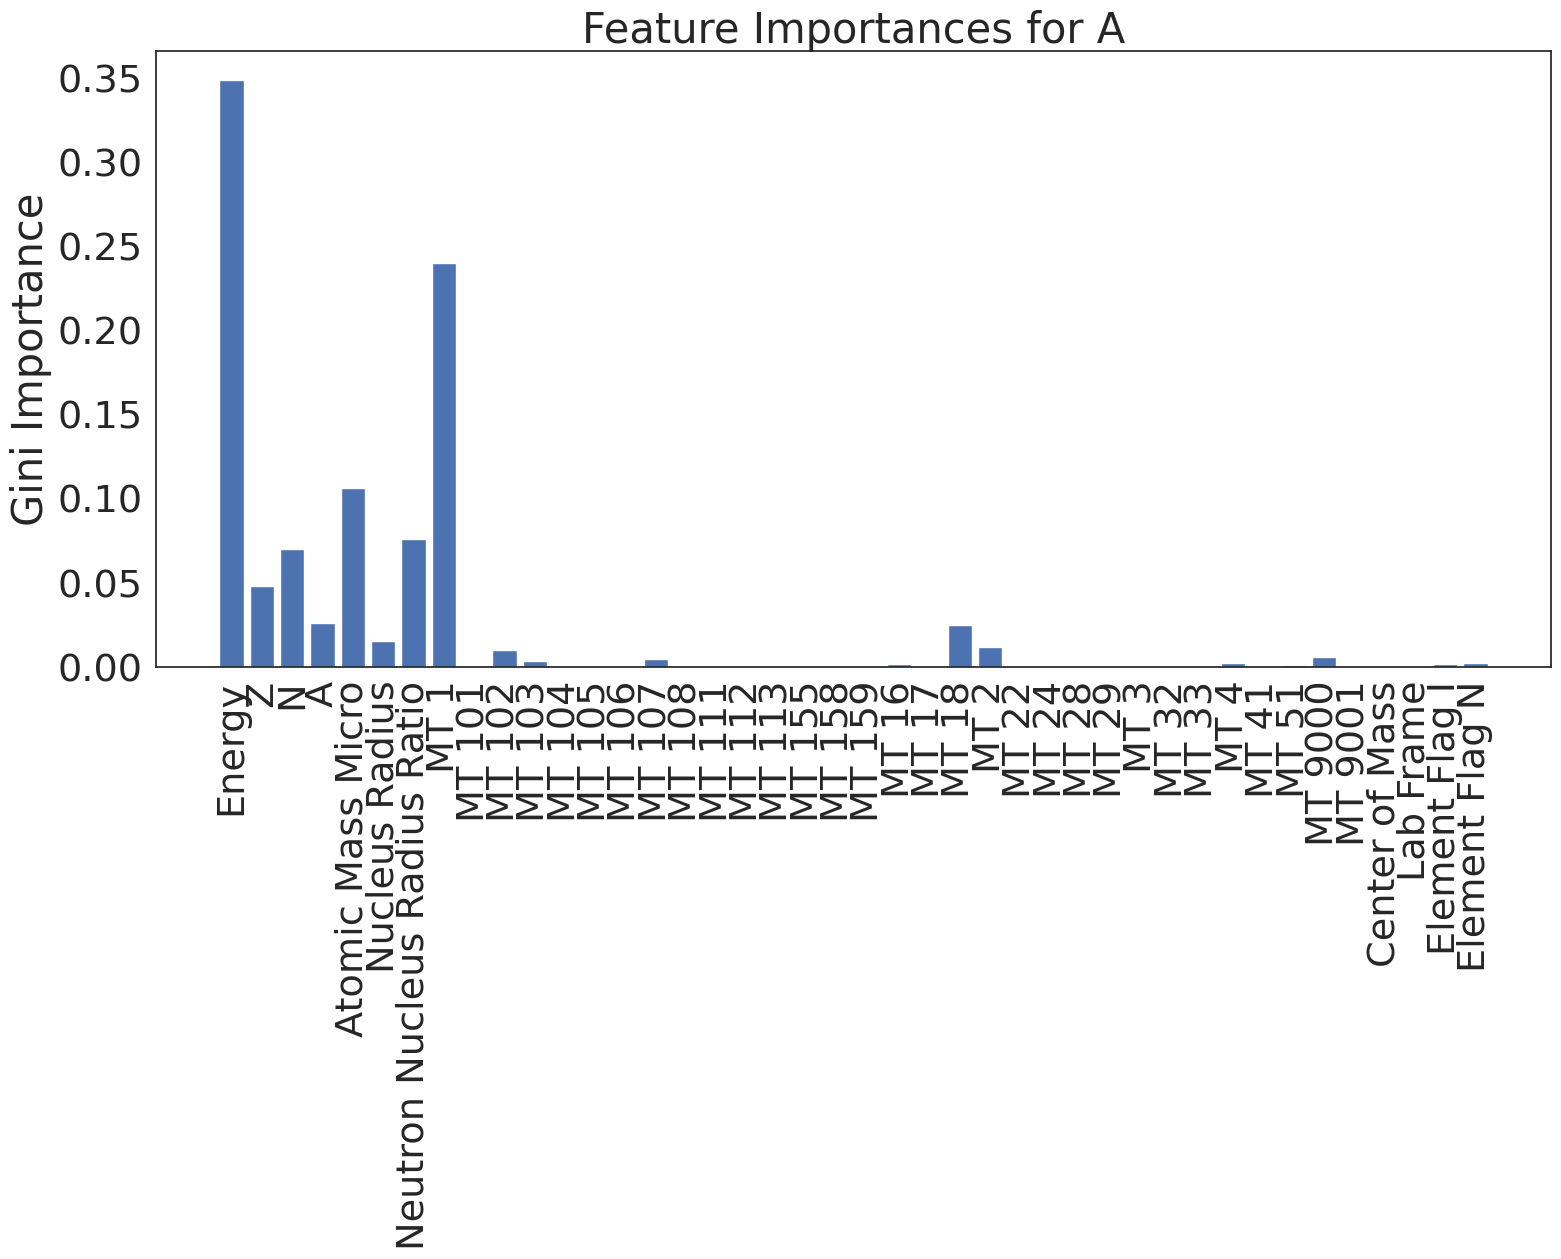

In [19]:

# Function to plot feature importances
def plot_feature_importances(model, feature_names, letter):
    plt.figure(figsize=(18, 8))
    plt.bar([x for x in range(len(model.feature_importances_))], model.feature_importances_)
    plt.xticks(np.arange(len(feature_names)), feature_names, rotation=90)
    plt.ylabel("Gini Importance")
    plt.title(f"Feature Importances for {letter}")
    #plt.savefig(f"figures/dt_feat_import_{letter}.png", bbox_inches='tight', dpi=300)
    plt.show()

# Loop through each letter in best_models_scalers to generate plots
for letter, data in best_models_scalers.items():
    model = data['model']
    feature_names = columns_dict[f'columns_{letter.upper()}']['data_columns'].tolist()
    plot_feature_importances(model, feature_names, letter)

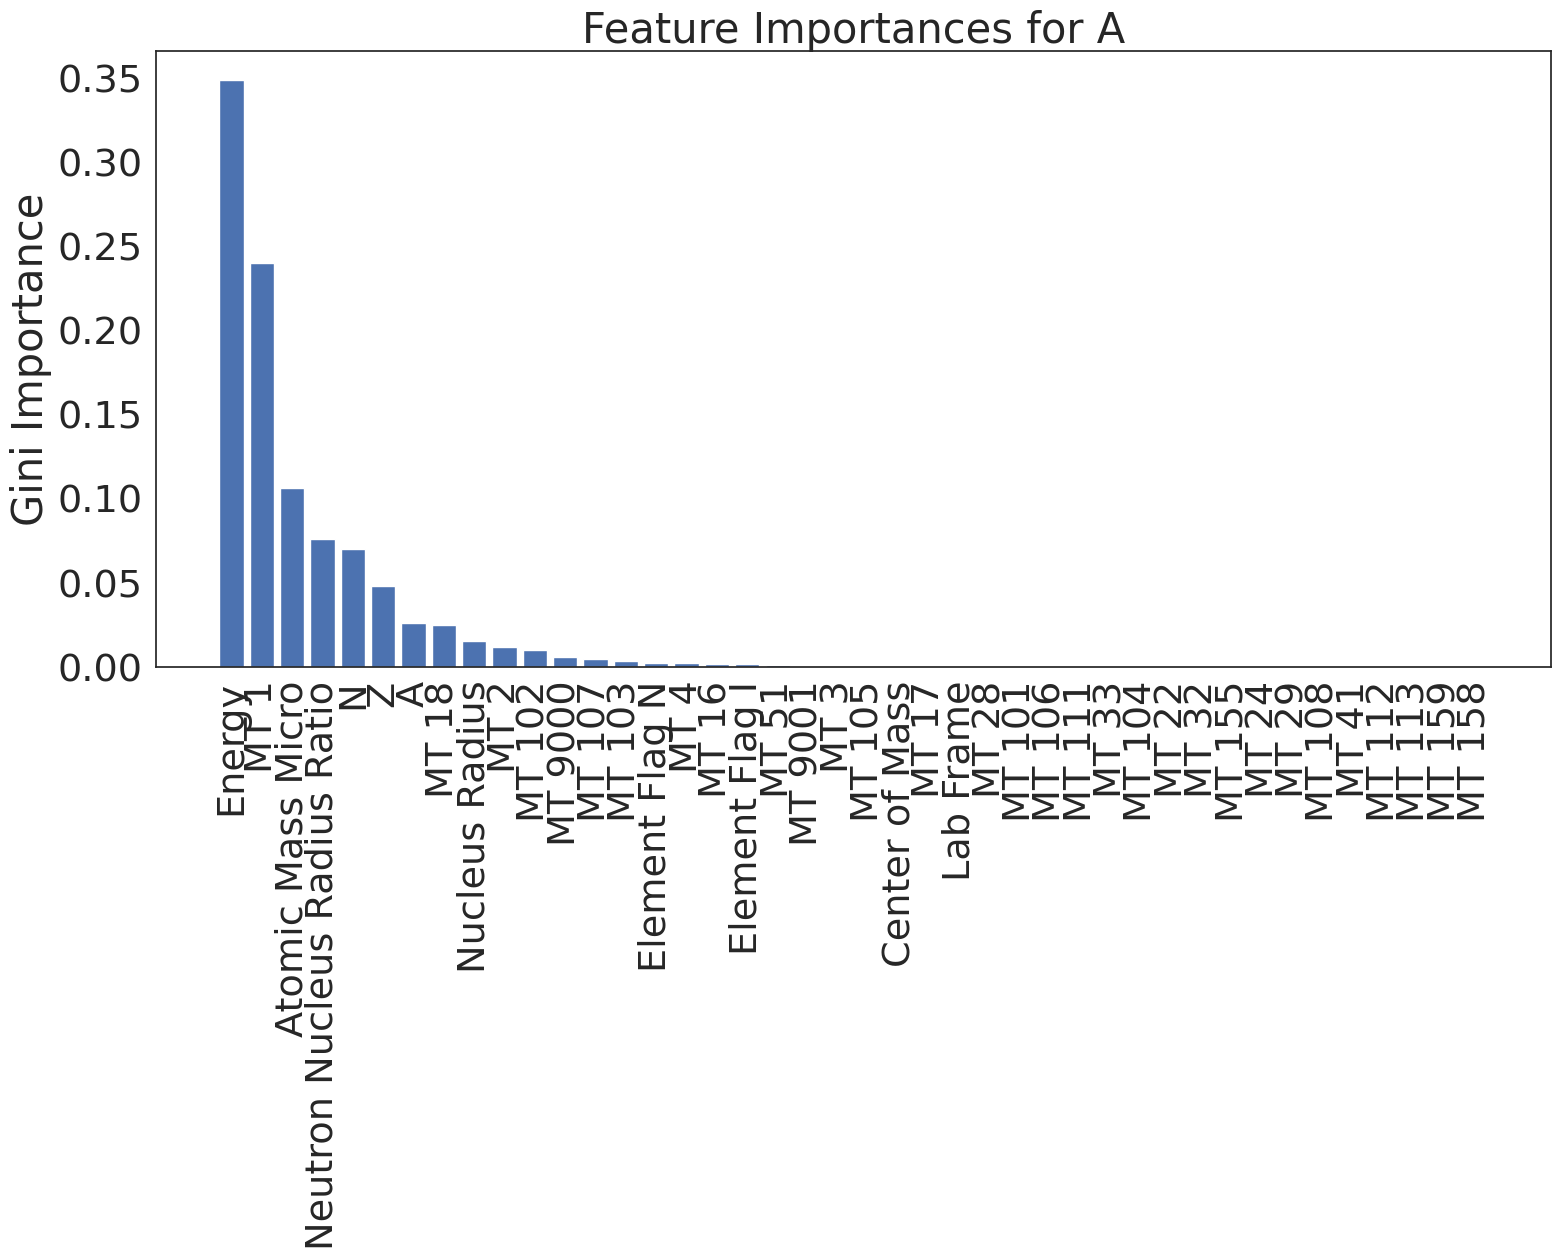

In [20]:
# Function to plot feature importances
def plot_feature_importances(model, feature_names, letter):
    # Get feature importances and sort them
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    plt.figure(figsize=(18, 8))
    plt.bar(range(len(sorted_importances)), sorted_importances)
    plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
    plt.ylabel("Gini Importance")
    plt.title(f"Feature Importances for {letter}")
    #plt.savefig(f"figures/dt_feat_import_{letter}.png", bbox_inches='tight', dpi=300)
    plt.show()

# Loop through each letter in best_models_scalers to generate plots
for letter, data in best_models_scalers.items():
    model = data['model']
    feature_names = columns_dict[f'columns_{letter.upper()}']['data_columns'].tolist()
    plot_feature_importances(model, feature_names, letter)

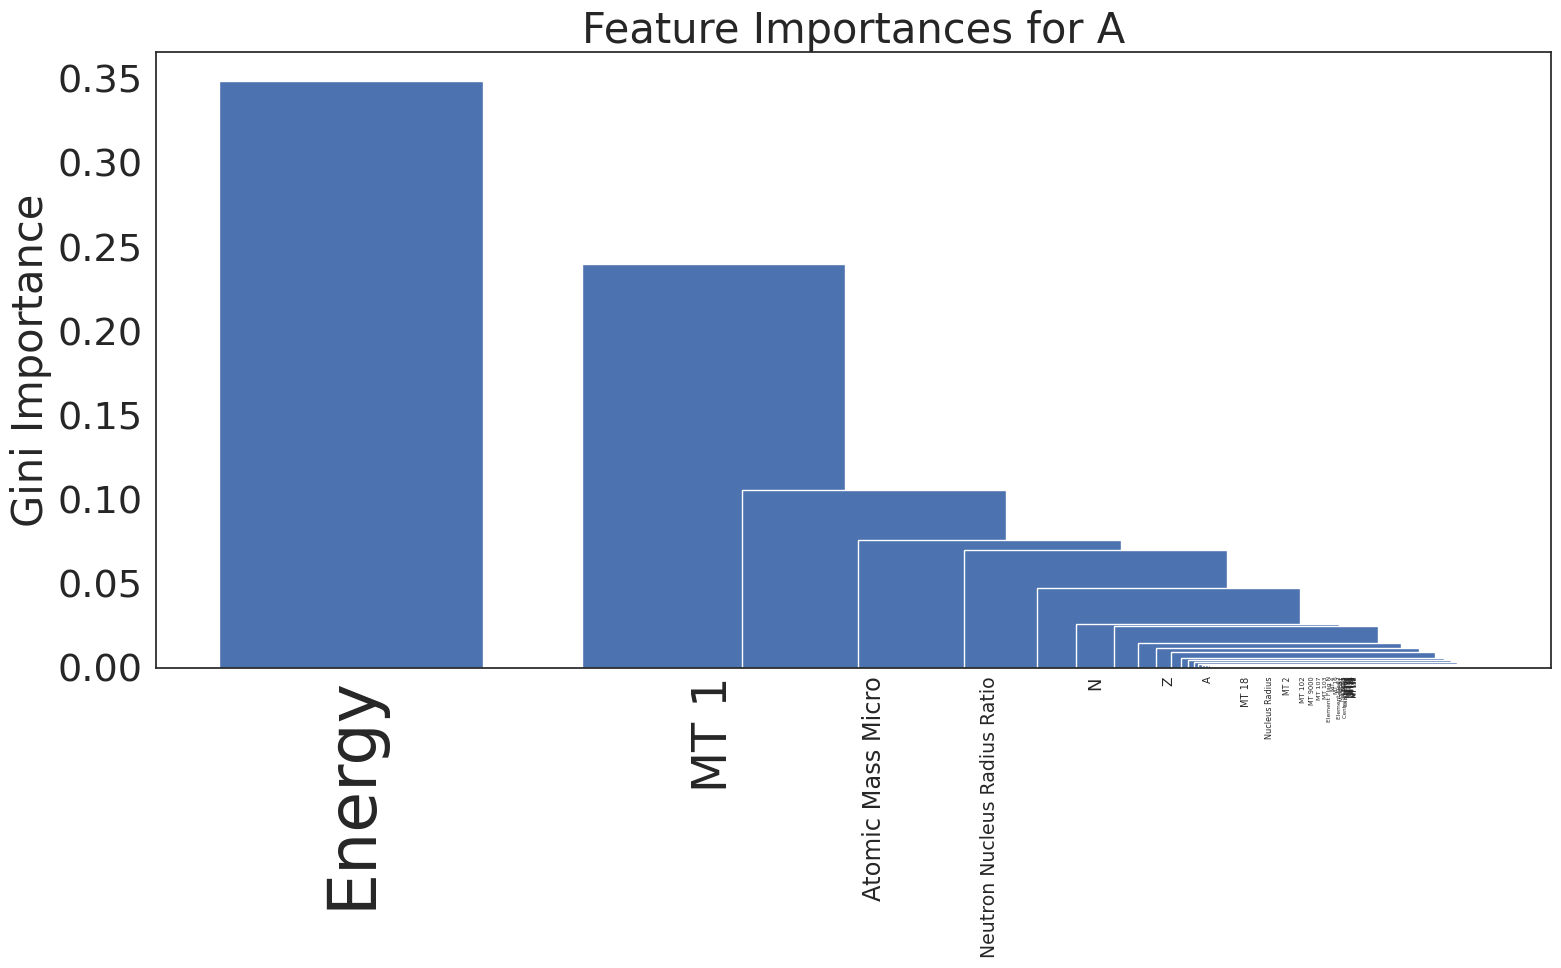

In [21]:

# Function to plot feature importances
def plot_feature_importances(model, feature_names, letter):
    # Get feature importances and sort them
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    sorted_feature_names = [feature_names[i] for i in indices]
    sorted_importances = importances[indices]

    # Calculate positions based on importance values
    min_gap = 0.001
    max_gap = 1.0
    norm_importances = (sorted_importances - sorted_importances.min()) / (sorted_importances.max() - sorted_importances.min())
    gaps = min_gap + norm_importances * (max_gap - min_gap)

    x_positions = np.cumsum(gaps) - gaps[0]  # Cumulative sum to get the x positions

    plt.figure(figsize=(18, 8))
    plt.bar(x_positions, sorted_importances, width=0.5)

    # Calculate font sizes based on importance values
    min_font_size = 4
    max_font_size = 48
    font_sizes = min_font_size + norm_importances * (max_font_size - min_font_size)

    # Set xticks with varying font sizes
    for i, (name, font_size, x) in enumerate(zip(sorted_feature_names, font_sizes, x_positions)):
        plt.text(x, -0.005, name, rotation=90, ha='center', va='top', fontsize=font_size)

    plt.xticks(x_positions, [])
    plt.ylabel("Gini Importance")
    plt.title(f"Feature Importances for {letter}")
    #plt.savefig(f"figures/dt_feat_import_{letter}.png", bbox_inches='tight', dpi=300)
    plt.show()

# Loop through each letter in best_models_scalers to generate plots
for letter, data in best_models_scalers.items():
    model = data['model']
    feature_names = columns_dict[f'columns_{letter.upper()}']['data_columns'].tolist()
    plot_feature_importances(model, feature_names, letter)
